## Import Libraries ##

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import sklearn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_auc_score

In [4]:
import math
from numpy import vstack
from torch.utils.data import Dataset
from pandas import read_csv
from torch.utils.data import DataLoader
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Tanh
from torch.nn import Sigmoid
from torch.nn import Module
from torch.nn.init import kaiming_uniform_
from torch.optim import SGD
from torch.optim import Adam
from torch.nn import BCELoss
import torch.nn as nn
import time

## Loading data sets and Pre-checking on the data ##

In [9]:
# loading the dataset
merged_data = pd.read_csv("merged_compustat_labels_text.csv")

In [10]:
# check dimensions of dataset
print("shape of the data:", merged_data.shape)

shape of the data: (263719, 533)


In [11]:
merged_data.head()

,gvkey,datadate,fyear,indfmt,consol,popsrc,datafmt,tic,cusip,conm,...,applicant,guilty,reprehensible,threat,restricting,selfishness,cik_year,ticker_year,cik_str,tic_fyear
0,1003,1990-01-31,1989,INDL,C,D,STD,ANTQ,000354100,A.A. IMPORTING CO INC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1004,1990-05-31,1989,INDL,C,D,STD,AIR,000361105,AAR CORP,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1004,1991-05-31,1990,INDL,C,D,STD,AIR,000361105,AAR CORP,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1004,1992-05-31,1991,INDL,C,D,STD,AIR,000361105,AAR CORP,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1004,1993-05-31,1992,INDL,C,D,STD,AIR,000361105,AAR CORP,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# duplicate value check for the column 'cik_fyear' in dataset 

merged_data['cik_fyear'].nunique()  

257596

In [ ]:
# checking data types of all columns in the dataset 1
merged_data.dtypes

In [ ]:
# checking for missing data
merged_data.isnull().sum()

In [ ]:
# checking for blanks

blank_values = (merged_data == '').sum()
print(blank_values)

## Preprocess merged dataset ##

### Treating null values ###

In [ ]:
# Filling missing values of merged dataset with 0
merged_data = merged_data.fillna(0)

# checking for missing data in merged dataset 
merged_data.isnull().sum()

In [19]:
merged_data = merged_data[merged_data.columns].replace([np.inf, -np.inf], 0)

### Dropping irrelevant columns ###

In [21]:
# Irrelevant columns to drop

columns_to_drop = ['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'target_word_frequency']

merged_data.drop(columns=columns_to_drop, inplace=True)

In [ ]:
# checking data types after dropping columns

merged_data.dtypes

### Normalisation of numeric columns ###

In [23]:
exclude_columns = ['gvkey', 'fyear', 'fyr', 'cik', 'sic', 'Bank', 'misstate', 'cik_x', 
                   'id', 'cik_y', 'year', 'accession_number', 'mda_section', 'cik_str', 'tic_fyear']

# Extract numeric columns
numeric_columns = merged_data.select_dtypes(include=['float64', 'int64']).columns

# Identify columns to normalize
columns_to_normalize = [col for col in numeric_columns if col not in exclude_columns]


In [ ]:
# Create a copy of the DataFrame to avoid modifying the original
normalized_data = merged_data.copy()

# Normalize the numeric columns excluding the specified columns
scaler = MinMaxScaler()
normalized_data[columns_to_normalize] = scaler.fit_transform(normalized_data[columns_to_normalize])

## Training and Test Data ##

In [ ]:
# checking the data types of the normalized data set
normalized_data.dtypes

### Splitting conditions - There are 14 financial ratios, 28 raw items and 454 text features ###

In [27]:
# Get the index of first text column

column_name_first = 'recklessness'  
column_index = normalized_data.columns.get_loc(column_name_first)

print("Index of column '{}' in normalized_data: {}".format(column_name_first, column_index))

Index of column 'recklessness' in normalized_data: 71


In [28]:
# Get the index of last text column

column_name_last = 'selfishness'  
column_index = normalized_data.columns.get_loc(column_name_last)

print("Index of column '{}' in normalized_data: {}".format(column_name_last, column_index))

Index of column 'selfishness' in normalized_data: 524


In [29]:
# Split features into the specified groups
raw_items_28 = ['act', 'ap', 'at', 'ceq', 'che', 'cogs', 'csho', 'dlc', 'dltis', 'dltt', 'dp', 'ib',
                       'invt', 'ivao', 'ivst', 'lct', 'lt', 'ni', 'ppegt', 'pstk', 're', 'rect', 'sale', 'sstk',
                       'txp', 'txt', 'xint','prcc_f']

In [30]:
financial_ratios_14 = ['dch_wc', 'ch_rsst', 'dch_rec', 'dch_inv', 'soft_assets', 'ch_cs', 'ch_cm', 'ch_roa', 'bm',
                          'dpi', 'reoa', 'EBIT', 'ch_fcf', 'issue']

In [31]:
raw_items_28_financial_ratios_14 = ['act', 'ap', 'at', 'ceq', 'che', 'cogs', 'csho', 'dlc', 'dltis', 'dltt', 'dp', 
                                    'ib', 'invt', 'ivao', 'ivst', 'lct', 'lt', 'ni', 'ppegt', 'pstk', 're', 'rect', 
                                    'sale', 'sstk', 'txp', 'txt', 'xint','prcc_f', 
                                    'dch_wc', 'ch_rsst', 'dch_rec', 'dch_inv', 'soft_assets','ch_cs', 'ch_cm', 
                                    'ch_roa', 'bm', 'dpi', 'reoa', 'EBIT', 'ch_fcf', 'issue']

In [32]:
# Select the raw features, financial ratios and text features from the dataframe

raw_features = normalized_data[raw_items_28]

financial_ratios = normalized_data[financial_ratios_14]

text_features = normalized_data.iloc[:, 71:525]  # As text features start from column index 71 and end at 524

raw_features_financial_ratios = normalized_data[raw_items_28_financial_ratios_14]

In [33]:
# Concatenate the raw features, financial ratios and text features along the columns
raw_items_28_fin_ratios_14_text_454 = pd.concat([raw_features_financial_ratios, text_features], axis=1)

# Print the shape of the resulting dataframe
print("Shape of raw_items_28_fin_ratios_14_text_454 dataframe:", raw_items_28_fin_ratios_14_text_454.shape)

Shape of raw_items_28_fin_ratios_14_text_454 dataframe: (263719, 496)


In [34]:
# Concatenate the raw features and text features along the columns
raw_items_28_text_454 = pd.concat([raw_features, text_features], axis=1)

# Print the shape of the resulting dataframe
print("Shape of raw_items_28_text_454 dataframe:", raw_items_28_text_454.shape)

Shape of raw_items_28_text_454 dataframe: (263719, 482)


In [35]:
# Concatenate the financial ratios and text features along the columns
fin_ratios_14_text_454 = pd.concat([financial_ratios, text_features], axis=1)

# Print the shape of the resulting dataframe
print("Shape of fin_ratios_14_text_454 dataframe:", fin_ratios_14_text_454.shape)

Shape of fin_ratios_14_text_454 dataframe: (263719, 468)


In [36]:
add_col = ['gvkey', 'fyear', 'tic', 'cik', 'Bank']

target_col = ['misstate']

# Combine add_col, raw_items_28_fin_ratios_14_text_454, and target_col
desired_columns_order = add_col + raw_items_28_fin_ratios_14_text_454.columns.tolist() + target_col

# Reorder the columns of normalized_data
normalized_data = normalized_data.reindex(columns = desired_columns_order)

# Print the shape of the resulting dataframe
print("Shape of normalized_data dataframe:", normalized_data.shape)

Shape of normalized_data dataframe: (263719, 502)


In [37]:
normalized_data.head()

,gvkey,fyear,tic,cik,Bank,act,ap,at,ceq,che,...,responsible,motive,conviction,applicant,guilty,reprehensible,threat,restricting,selfishness,misstate
0,1003,1989,ANTQ,730052.0,0,0.000071,9.710422e-07,0.000002,0.216608,0.000008,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1004,1989,AIR,1750.0,0,0.001182,1.456401e-05,0.000090,0.216902,0.000011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,1004,1990,AIR,1750.0,0,0.001152,1.426266e-05,0.000088,0.216909,0.000009,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,1004,1991,AIR,1750.0,0,0.001240,1.763227e-05,0.000092,0.216914,0.000012,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,1004,1992,AIR,1750.0,0,0.001138,1.320918e-05,0.000085,0.216902,0.000010,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


### Plotting the fraud data over time period ###

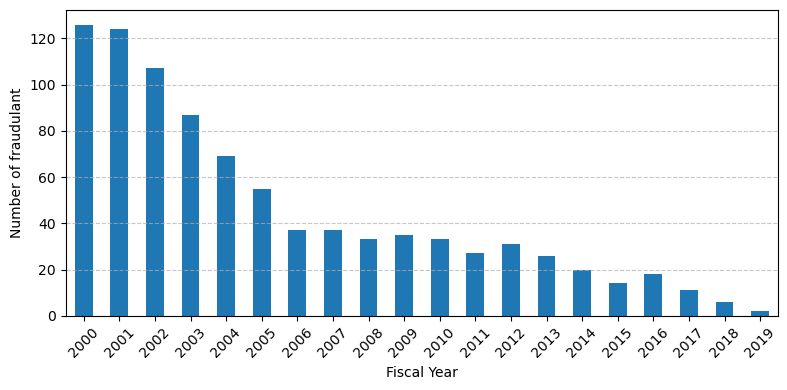

Total number of fraudulant from 2000 to 2019: 898
Total number of fraudulant in the training period from 2000 to 2004: 513
Total number of fraudulant in the testing period from 2005 to 2019: 385


In [43]:
# Filter the DataFrame for years from 2000 to 2019
filtered_df = normalized_data[(normalized_data['fyear'] >= 2000) & (normalized_data['fyear'] <= 2019)]
training_df = normalized_data[(normalized_data['fyear'] >= 2000) & (normalized_data['fyear'] <= 2004)]
testing_df = normalized_data[(normalized_data['fyear'] >= 2005) & (normalized_data['fyear'] <= 2019)]

# Group by fiscal year and sum misstatements
misstatements_by_fyear = filtered_df.groupby('fyear')['misstate'].sum()
misstatements_by_fyear_training = training_df.groupby('fyear')['misstate'].sum()
misstatements_by_fyear_testing = testing_df.groupby('fyear')['misstate'].sum()

# Calculate total misstatements
total_misstatements = misstatements_by_fyear.sum()
total_misstatements_training = misstatements_by_fyear_training.sum()
total_misstatements_testing = misstatements_by_fyear_testing.sum()

# Plotting
plt.figure(figsize=(8, 4))
misstatements_by_fyear.plot(kind='bar')
plt.xlabel('Fiscal Year')
plt.ylabel('Number of fraudulant')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print total misstatements
print("Total number of fraudulant from 2000 to 2019:", total_misstatements)
print("Total number of fraudulant in the training period from 2000 to 2004:", total_misstatements_training)
print("Total number of fraudulant in the testing period from 2005 to 2019:", total_misstatements_testing)

### Train, Test data ###

In [44]:
# Assign Train, and Test periods
train_period, test_period = (2000, 2004), (2005, 2019)

In [45]:
# loading data

train_data = normalized_data[(normalized_data['fyear'] >= train_period[0]) & (normalized_data['fyear'] <= train_period[1])]
test_data = normalized_data[(normalized_data['fyear'] >= test_period[0]) & (normalized_data['fyear'] <= test_period[1])]

In [46]:
# Extract features (X) and target variable (y) for training and testing
X_train = train_data[raw_items_28_fin_ratios_14_text_454.columns]
y_train = train_data['misstate']

X_test = test_data[raw_items_28_fin_ratios_14_text_454.columns]
y_test = test_data['misstate']

In [47]:
X_train.shape

(44213, 496)

### Treating undersampling (RUS) ###

In [48]:
# Undersampling the data
rus = RandomUnderSampler()
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

print("Training data Shape after under sampling:", X_train_resampled.shape, y_train_resampled.shape)

Training data Shape after under sampling: (1026, 496) (1026,)


### Extraction of features and preparing the train and test sets with 'misstate' column ###

In [49]:
# Get the index of first text column

column_name_first_ = 'recklessness'  
column_index_ = normalized_data.columns.get_loc(column_name_first_)

print("Index of column '{}' in normalized_data: {}".format(column_name_first_, column_index_))

Index of column 'recklessness' in normalized_data: 47


In [50]:
column_name_last_ = 'selfishness'  
column_index_ = normalized_data.columns.get_loc(column_name_last_)

print("Index of column '{}' in normalized_data: {}".format(column_name_last_, column_index_))

Index of column 'selfishness' in normalized_data: 500


In [51]:
text_items_454 = normalized_data.iloc[:, 47:501]

In [52]:
text_items_454.head()

,recklessness,guarantor,hazard,constrains,despicable,refusal,restitution,dependance,constrain,prevented,...,condemnation,responsible,motive,conviction,applicant,guilty,reprehensible,threat,restricting,selfishness
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
# Extract raw items for training set
X_train_resampled_28 = X_train_resampled.loc[:, raw_items_28]
y_train_resampled_28 = y_train_resampled

# Extract raw items for testing set
X_test_28 = X_test.loc[:, raw_items_28]
y_test_28 = y_test


In [54]:
# Extract financial ratios for training set
X_train_resampled_14 = X_train_resampled.loc[:, financial_ratios_14]
y_train_resampled_14 = y_train_resampled

# Extract financial ratios for training set
X_test_14 = X_test.loc[:, financial_ratios_14]
y_test_14 = y_test

In [55]:
# Define the text feature column names
text_feature_columns = text_items_454.columns.tolist()

# Remove the target column from text feature columns if present
#text_feature_columns = [col for col in text_feature_columns if col != 'misstate']

# Extract text features for training set
X_train_resampled_454 = X_train_resampled.loc[:, text_feature_columns]
y_train_resampled_454 = y_train_resampled

# Extract text features for testing set
X_test_454 = X_test.loc[:, text_feature_columns]
y_test_454 = y_test


In [118]:
raw_items_28_financial_ratios_14 = ['act', 'ap', 'at', 'ceq', 'che', 'cogs', 'csho', 'dlc', 'dltis', 'dltt', 'dp', 
                                    'ib', 'invt', 'ivao', 'ivst', 'lct', 'lt', 'ni', 'ppegt', 'pstk', 're', 'rect', 
                                    'sale', 'sstk', 'txp', 'txt', 'xint','prcc_f', 
                                    'dch_wc', 'ch_rsst', 'dch_rec', 'dch_inv', 'soft_assets','ch_cs', 'ch_cm', 
                                    'ch_roa', 'bm', 'dpi', 'reoa', 'EBIT', 'ch_fcf', 'issue']

# Extract financial ratios and raw items for training set
X_train_resampled_42 = X_train_resampled.loc[:, raw_items_28_financial_ratios_14]
y_train_resampled_42 = y_train_resampled

# Extract financial ratios and raw items for training set
X_test_42 = X_test.loc[:, raw_items_28_financial_ratios_14]
y_test_42 = y_test

In [141]:
financial_ratios_14 = ['dch_wc', 'ch_rsst', 'dch_rec', 'dch_inv', 'soft_assets', 'ch_cs', 'ch_cm', 'ch_roa', 'bm',
                          'dpi', 'reoa', 'EBIT', 'ch_fcf', 'issue']


# Select the raw features and text features from the dataframe
financial_features = normalized_data[financial_ratios_14]
text_features = normalized_data.iloc[:, 47:501]  # As text features start from column index 47 and end at 500


# Concatenate the raw features and text features along the columns
financial_14_text_454 = pd.concat([financial_features, text_features], axis=1)

# Print the shape of the resulting dataframe
print("Shape of financial_14_text_454 dataframe:", financial_14_text_454.shape)


Shape of financial_14_text_454 dataframe: (263719, 468)


In [143]:
# Extract financial ratios and text for training set
X_train_resampled_468 = X_train_resampled[financial_14_text_454.columns]
y_train_resampled_468 = y_train_resampled

# Extract financial ratios and text items for training set
X_test_468 = X_test[financial_14_text_454.columns]
y_test_468 = y_test

In [136]:
raw_items_28 = ['act', 'ap', 'at', 'ceq', 'che', 'cogs', 'csho', 'dlc', 'dltis', 'dltt', 'dp', 'ib',
                       'invt', 'ivao', 'ivst', 'lct', 'lt', 'ni', 'ppegt', 'pstk', 're', 'rect', 'sale', 'sstk',
                       'txp', 'txt', 'xint','prcc_f']

# Select the raw features and text features from the dataframe
raw_features = normalized_data[raw_items_28]
text_features = normalized_data.iloc[:, 47:501]  # As text features start from column index 47 and end at 500


# Concatenate the raw features and text features along the columns
raw_items_28_text_454 = pd.concat([raw_features, text_features], axis=1)

# Print the shape of the resulting dataframe
print("Shape of raw_items_28_text_454 dataframe:", raw_items_28_text_454.shape)

Shape of raw_items_28_text_454 dataframe: (263719, 482)


In [138]:
# Extract text and raw items for training set
X_train_resampled_482 = X_train_resampled[raw_items_28_text_454.columns]
y_train_resampled_482 = y_train_resampled

# Extract text and raw items for testing set
X_test_482 = X_test[raw_items_28_text_454.columns]
y_test_482 = y_test

In [56]:
merged_train_data = pd.concat([X_train_resampled, y_train_resampled], axis = 1)
merged_test_data = pd.concat([X_test, y_test], axis = 1)

merged_train_data_28 = pd.concat([X_train_resampled_28, y_train_resampled_28], axis = 1)
merged_test_data_28 = pd.concat([X_test_28, y_test_28], axis = 1)

merged_train_data_454 = pd.concat([X_train_resampled_454, y_train_resampled_454], axis = 1)
merged_test_data_454 = pd.concat([X_test_454, y_test_454], axis = 1)

merged_train_data_14 = pd.concat([X_train_resampled_14, y_train_resampled_14], axis = 1)
merged_test_data_14 = pd.concat([X_test_14, y_test_14], axis = 1)

In [119]:
merged_train_data_42 = pd.concat([X_train_resampled_42, y_train_resampled_42], axis = 1)
merged_test_data_42 = pd.concat([X_test_42, y_test_42], axis = 1)

In [139]:
merged_train_data_482 = pd.concat([X_train_resampled_482, y_train_resampled_482], axis = 1)
merged_test_data_482 = pd.concat([X_test_482, y_test_482], axis = 1)

In [144]:
merged_train_data_468 = pd.concat([X_train_resampled_468, y_train_resampled_468], axis = 1)
merged_test_data_468 = pd.concat([X_test_468, y_test_468], axis = 1)

In [58]:
# Saving to drive/ folder

merged_train_data.to_csv('D:/Project Work/data_42_text/merged_train_data.csv', index=False)
merged_test_data.to_csv('D:/Project Work/data_42_text/merged_test_data.csv', index=False)

merged_train_data_28.to_csv('D:/Project Work/data_42_text/merged_train_data_28.csv', index=False)
merged_test_data_28.to_csv('D:/Project Work/data_42_text/merged_test_data_28.csv', index=False)

merged_train_data_454.to_csv('D:/Project Work/data_42_text/merged_train_data_454.csv', index=False)
merged_test_data_454.to_csv('D:/Project Work/data_42_text/merged_test_data_454.csv', index=False)

merged_train_data_14.to_csv('D:/Project Work/data_42_text/merged_train_data_14.csv', index=False)
merged_test_data_14.to_csv('D:/Project Work/data_42_text/merged_test_data_14.csv', index=False)

In [120]:
merged_train_data_42.to_csv('D:/Project Work/data_42_text/merged_train_data_42.csv', index=False)
merged_test_data_42.to_csv('D:/Project Work/data_42_text/merged_test_data_42.csv', index=False)

In [140]:
merged_train_data_482.to_csv('D:/Project Work/data_42_text/merged_train_data_482.csv', index=False)
merged_test_data_482.to_csv('D:/Project Work/data_42_text/merged_test_data_482.csv', index=False)

In [145]:
merged_train_data_468.to_csv('D:/Project Work/data_42_text/merged_train_data_468.csv', index=False)
merged_test_data_468.to_csv('D:/Project Work/data_42_text/merged_test_data_468.csv', index=False)

## Model Training with Logit ##

In [146]:
class CSVDataset(Dataset):
    #Constructor for initially loading
    def __init__(self, path):
        df = read_csv(path, header=0)
        self.X = df.values[0:, :-1]
        self.y = df.values[0:, -1]
        self.X = self.X.astype('float32')
        self.y = self.y.astype('float32')
        self.y = self.y.reshape((len(self.y), 1))

        print(self.X.shape)
        print(self.y.shape)

    # Get the number of rows in the dataset
    def __len__(self):
        return len(self.X)
    # Get a row at an index
    def __getitem__(self,idx):
        return [self.X[idx], self.y[idx]]

In [147]:
def prepare_train_dataset(path):
    train1 = CSVDataset(path)
    train_dl = DataLoader(train1, batch_size = 1026, shuffle=False)
    return train_dl

def prepare_test_dataset(path):
    test1 = CSVDataset(path)
    test_dl = DataLoader(test1, batch_size = 1024, shuffle=False)
    return test_dl

In [87]:
# Importing the data sets from saved folder

train_dl_496 = prepare_train_dataset('D:/Project Work/data_42_text/merged_train_data.csv')
test_dl_496 = prepare_test_dataset('D:/Project Work/data_42_text/merged_test_data.csv')

train_dl_28 = prepare_train_dataset('D:/Project Work/data_42_text/merged_train_data_28.csv')
test_dl_28 = prepare_test_dataset('D:/Project Work/data_42_text/merged_test_data_28.csv')

train_dl_454 = prepare_train_dataset('D:/Project Work/data_42_text/merged_train_data_454.csv')
test_dl_454 = prepare_test_dataset('D:/Project Work/data_42_text/merged_test_data_454.csv')

train_dl_14 = prepare_train_dataset('D:/Project Work/data_42_text/merged_train_data_14.csv')
test_dl_14 = prepare_test_dataset('D:/Project Work/data_42_text/merged_test_data_14.csv')

(1026, 496)
(1026, 1)
(108811, 496)
(108811, 1)
(1026, 28)
(1026, 1)
(108811, 28)
(108811, 1)
(1026, 454)
(1026, 1)
(108811, 454)
(108811, 1)
(1026, 14)
(1026, 1)
(108811, 14)
(108811, 1)


In [121]:
train_dl_42 = prepare_train_dataset('D:/Project Work/data_42_text/merged_train_data_42.csv')
test_dl_42 = prepare_test_dataset('D:/Project Work/data_42_text/merged_test_data_42.csv')

(1026, 42)
(1026, 1)
(108811, 42)
(108811, 1)


In [148]:
train_dl_482 = prepare_train_dataset('D:/Project Work/data_42_text/merged_train_data_482.csv')
test_dl_482 = prepare_test_dataset('D:/Project Work/data_42_text/merged_test_data_482.csv')

(1026, 482)
(1026, 1)
(108811, 482)
(108811, 1)


In [149]:
train_dl_468 = prepare_train_dataset('D:/Project Work/data_42_text/merged_train_data_468.csv')
test_dl_468 = prepare_test_dataset('D:/Project Work/data_42_text/merged_test_data_468.csv')

(1026, 468)
(1026, 1)
(108811, 468)
(108811, 1)


### Logistic Regression  ###

In [150]:
class Logistic_Regression(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.layer0 = nn.Linear(in_features=num_features, out_features=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.layer0(x)
        x = self.sigmoid(x)
        return x

In [151]:
# Function to train the model

def train_model(model, train_dl, num_epochs):

    # Define loss function and optimizer
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_dl:
            optimizer.zero_grad()
            outputs = model(inputs.float())
            labels = labels.float()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_dl.dataset)

In [152]:
# Function for model evaluation

def evaluate_model(model, test_dl):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_dl:
            outputs = model(inputs.float())
            y_true.extend(labels.numpy())
            y_pred.extend(outputs.numpy().flatten())
    auc = roc_auc_score(y_true, y_pred)
    print(f"AUC: {auc:.4f}")

In [91]:
model_496 = Logistic_Regression(496)

In [92]:
train_model(model_496, train_dl_496, num_epochs=150)

In [94]:
evaluate_model(model_496, test_dl_496)

AUC: 0.5956


## Model performance check ##  

### Evaluate for total data with 28 raw items, 14 financial ratios and 454 text features  ###

In [96]:
auc_values = []

# Perform 10 training runs
for i in range(10):
    model_496 = Logistic_Regression(496)
    train_model(model_496, train_dl_496, num_epochs=150)

    # Evaluate the model
    model_496.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_dl_496:
            outputs = model_496(inputs.float())
            y_true.extend(labels.numpy())
            y_pred.extend(outputs.numpy().flatten())
    auc = roc_auc_score(y_true, y_pred)
    auc_values.append(auc)  # Append AUC to the list
    print(f"Run {i+1}: AUC = {auc:.4f}")

# Calculate the average AUC
average_auc = np.mean(auc_values)
print(f"\nAverage AUC: {average_auc:.4f}")

# Calculate the std AUC
auc_std_dev = np.std(auc_values)
print(f"Standard Deviation of AUC: {auc_std_dev:.4f}")

Run 1: AUC = 0.5908
Run 2: AUC = 0.5889
Run 3: AUC = 0.5657
Run 4: AUC = 0.5776
Run 5: AUC = 0.5823
Run 6: AUC = 0.5854
Run 7: AUC = 0.5951
Run 8: AUC = 0.5765
Run 9: AUC = 0.5879
Run 10: AUC = 0.5762

Average AUC: 0.5826
Standard Deviation of AUC: 0.0083


### Evaluate for 28 raw items  ###

In [131]:
model_28 = Logistic_Regression(28)

In [133]:
train_model(model_28, train_dl_28, num_epochs=150)

In [134]:
evaluate_model(model_28, test_dl_28)

AUC: 0.5524


In [163]:
auc_values_28 = []

# Perform 10 training runs
for i in range(10):
    model_28 = Logistic_Regression(28)
    train_model(model_28, train_dl_28, num_epochs=150)

    # Evaluate the model
    model_28.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_dl_28:
            outputs = model_28(inputs.float())
            y_true.extend(labels.numpy())
            y_pred.extend(outputs.numpy().flatten())
    auc_28 = roc_auc_score(y_true, y_pred)
    auc_values_28.append(auc_28)  # Append AUC to the list
    print(f"Run {i+1}: AUC = {auc_28:.4f}")

# Calculate the average AUC
average_auc_28 = np.mean(auc_values_28)
print(f"\nAverage AUC: {average_auc_28:.4f}")

# Calculate the std AUC
auc_std_dev_28 = np.std(auc_values_28)
print(f"Standard Deviation of AUC: {auc_std_dev_28:.4f}")

Run 1: AUC = 0.5017
Run 2: AUC = 0.5324
Run 3: AUC = 0.5442
Run 4: AUC = 0.5530
Run 5: AUC = 0.4620
Run 6: AUC = 0.5480
Run 7: AUC = 0.5488
Run 8: AUC = 0.5016
Run 9: AUC = 0.5781
Run 10: AUC = 0.5610

Average AUC: 0.5331
Standard Deviation of AUC: 0.0329


### Evaluate for 454 text features  ###

In [101]:
model_454 = Logistic_Regression(454)

In [102]:
train_model(model_454, train_dl_454, num_epochs=150)

In [103]:
evaluate_model(model_454, test_dl_454)

AUC: 0.5090


In [164]:
auc_values_454 = []

# Perform 10 training runs
for i in range(10):
    model_454 = Logistic_Regression(454)
    train_model(model_454, train_dl_454, num_epochs=150)

    # Evaluate the model
    model_454.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_dl_454:
            outputs = model_454(inputs.float())
            y_true.extend(labels.numpy())
            y_pred.extend(outputs.numpy().flatten())
    auc_454 = roc_auc_score(y_true, y_pred)
    auc_values_454.append(auc_454)  # Append AUC to the list
    print(f"Run {i+1}: AUC = {auc_454:.4f}")

# Calculate the average AUC
average_auc_454 = np.mean(auc_values_454)
print(f"\nAverage AUC: {average_auc_454:.4f}")

auc_std_dev_454 = np.std(auc_values_454)
print(f"Standard Deviation of AUC: {auc_std_dev_454:.4f}")

Run 1: AUC = 0.4862
Run 2: AUC = 0.5117
Run 3: AUC = 0.4952
Run 4: AUC = 0.5015
Run 5: AUC = 0.5094
Run 6: AUC = 0.5283
Run 7: AUC = 0.5126
Run 8: AUC = 0.5163
Run 9: AUC = 0.5129
Run 10: AUC = 0.5102

Average AUC: 0.5084
Standard Deviation of AUC: 0.0111


### Evaluate for 14 financial ratios

In [105]:
model_14 = Logistic_Regression(14)

In [106]:
train_model(model_14, train_dl_14, num_epochs=150)

In [107]:
evaluate_model(model_14, test_dl_14)

AUC: 0.5875


In [108]:
auc_values_14 = []

# Perform 10 training runs
for i in range(10):
    model_14 = Logistic_Regression(14)
    train_model(model_14, train_dl_14, num_epochs=150)

    # Evaluate the model
    model_14.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_dl_14:
            outputs = model_14(inputs.float())
            y_true.extend(labels.numpy())
            y_pred.extend(outputs.numpy().flatten())
    auc_14 = roc_auc_score(y_true, y_pred)
    auc_values_14.append(auc_14)  # Append AUC to the list
    print(f"Run {i+1}: AUC = {auc_14:.4f}")

# Calculate the average AUC
average_auc_14 = np.mean(auc_values_14)
print(f"\nAverage AUC: {average_auc_14:.4f}")

auc_std_dev_14 = np.std(auc_values_14)
print(f"Standard Deviation of AUC: {auc_std_dev_14:.4f}")

Run 1: AUC = 0.4933
Run 2: AUC = 0.5095
Run 3: AUC = 0.4803
Run 4: AUC = 0.4797
Run 5: AUC = 0.5187
Run 6: AUC = 0.5887
Run 7: AUC = 0.5929
Run 8: AUC = 0.5132
Run 9: AUC = 0.4839
Run 10: AUC = 0.5904

Average AUC: 0.5251
Standard Deviation of AUC: 0.0449


### Evaluate for 28 raw items and 14 financial ratios

In [127]:
model_42 = Logistic_Regression(42)

In [128]:
train_model(model_42, train_dl_42, num_epochs=150)


In [129]:
evaluate_model(model_42, test_dl_42)

AUC: 0.5785


In [130]:
auc_values = []

# Perform 10 training runs
for i in range(10):
    model_42 = Logistic_Regression(42)
    train_model(model_42, train_dl_42, num_epochs=150)

    # Evaluate the model
    model_42.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_dl_42:
            outputs = model_42(inputs.float())
            y_true.extend(labels.numpy())
            y_pred.extend(outputs.numpy().flatten())
    auc = roc_auc_score(y_true, y_pred)
    auc_values.append(auc)  # Append AUC to the list
    print(f"Run {i+1}: AUC = {auc:.4f}")

# Calculate the average AUC
average_auc = np.mean(auc_values)
print(f"\nAverage AUC: {average_auc:.4f}")

# Calculate the std AUC
auc_std_dev = np.std(auc_values)
print(f"Standard Deviation of AUC: {auc_std_dev:.4f}")

Run 1: AUC = 0.5785
Run 2: AUC = 0.5786
Run 3: AUC = 0.5784
Run 4: AUC = 0.5781
Run 5: AUC = 0.5781
Run 6: AUC = 0.5784
Run 7: AUC = 0.5785
Run 8: AUC = 0.5784
Run 9: AUC = 0.5783
Run 10: AUC = 0.5784

Average AUC: 0.5784
Standard Deviation of AUC: 0.0001


### Evaluate for 28 raw items and 454 text features

In [153]:
model_482 = Logistic_Regression(482)

In [154]:
train_model(model_482, train_dl_482, num_epochs=150)

In [155]:
evaluate_model(model_482, test_dl_482)

AUC: 0.5262


In [165]:
auc_values = []

# Perform 10 training runs
for i in range(10):
    model_482 = Logistic_Regression(482)
    train_model(model_482, train_dl_482, num_epochs=150)

    # Evaluate the model
    model_482.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_dl_482:
            outputs = model_482(inputs.float())
            y_true.extend(labels.numpy())
            y_pred.extend(outputs.numpy().flatten())
    auc = roc_auc_score(y_true, y_pred)
    auc_values.append(auc)  # Append AUC to the list
    print(f"Run {i+1}: AUC = {auc:.4f}")

# Calculate the average AUC
average_auc = np.mean(auc_values)
print(f"\nAverage AUC: {average_auc:.4f}")

# Calculate the std AUC
auc_std_dev = np.std(auc_values)
print(f"Standard Deviation of AUC: {auc_std_dev:.4f}")

Run 1: AUC = 0.5375
Run 2: AUC = 0.4756
Run 3: AUC = 0.5341
Run 4: AUC = 0.5371
Run 5: AUC = 0.5371
Run 6: AUC = 0.5145
Run 7: AUC = 0.5378
Run 8: AUC = 0.5152
Run 9: AUC = 0.5216
Run 10: AUC = 0.5366

Average AUC: 0.5247
Standard Deviation of AUC: 0.0187


### Evaluate for 14 financial ratios and 454 text features

In [157]:
model_468 = Logistic_Regression(468)

In [158]:
train_model(model_468, train_dl_468, num_epochs=150)

In [159]:
evaluate_model(model_468, test_dl_468)

AUC: 0.5795


In [161]:
auc_values = []

# Perform 10 training runs
for i in range(10):
    model_468 = Logistic_Regression(468)
    train_model(model_468, train_dl_468, num_epochs=150)

    # Evaluate the model
    model_468.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_dl_468:
            outputs = model_468(inputs.float())
            y_true.extend(labels.numpy())
            y_pred.extend(outputs.numpy().flatten())
    auc = roc_auc_score(y_true, y_pred)
    auc_values.append(auc)  # Append AUC to the list
    print(f"Run {i+1}: AUC = {auc:.4f}")

# Calculate the average AUC
average_auc = np.mean(auc_values)
print(f"\nAverage AUC: {average_auc:.4f}")

# Calculate the std AUC
auc_std_dev = np.std(auc_values)
print(f"Standard Deviation of AUC: {auc_std_dev:.4f}")

Run 1: AUC = 0.5841
Run 2: AUC = 0.6044
Run 3: AUC = 0.5799
Run 4: AUC = 0.5685
Run 5: AUC = 0.5992
Run 6: AUC = 0.5990
Run 7: AUC = 0.5850
Run 8: AUC = 0.5947
Run 9: AUC = 0.5939
Run 10: AUC = 0.5747

Average AUC: 0.5883
Standard Deviation of AUC: 0.0111
